Combustion Engines identification using Machine Learning techniques

USP Esalq - MBA Data Science & Analytics - 2022/2

Matheus Felipe Sozza

# 1. Libraries Installing and Importing

## 1.1. Install and Import libraries

In [1]:
#pip install librosa numpy pandas matplotlib scipy sklearn IPython mir_eval dill

In [2]:
# Import modules
%matplotlib inline
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
import scipy.signal
import math
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 1.2. Import **Audio** files and **Metadata** from file system

In [3]:
PROJECT_PATH = 'C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/'
METADATA_FILE = PROJECT_PATH + 'DatasetMapping.csv'
AUDIOS_PATH = PROJECT_PATH + 'UrbanSounds8k'

In [4]:
#Create a dataframe for the metadata table
metadata_DF = pd.read_csv(METADATA_FILE)

# 2. **Audios Dataset** creation (Pandas)

## 2.1. Create **Audios Dataset** from **Metadata Dataset**

In [5]:
# View original dataset format
metadata_DF.head()

,dataset,slice_file_name,fsID,start,end,salience,fold,classID,class,macro_class
0,UrbanSounds8K,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,urbanSound
1,UrbanSounds8K,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,urbanSound
2,UrbanSounds8K,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,urbanSound
3,UrbanSounds8K,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,urbanSound
4,UrbanSounds8K,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,urbanSound


In [6]:
# Create audio DataFrame
audios_DF = pd.DataFrame({
"filename": [],
"duration":[],
"class":[]
});

n_files = 0
for index, dfRow in metadata_DF.iterrows():
  # Get audio file path
  audioFilePath = AUDIOS_PATH + '/' + dfRow['slice_file_name']
  
  # Provide feedback to the user
  if (n_files % 1000 == 0):
    print(audioFilePath, " ---> Index: ", index) #Verbose
  
  # Compile results or provide error feedback
  if not os.path.exists(audioFilePath):
    print(dfRow['slice_file_name'] + " (index=" + str(n_files) + ") does not exist!")
  else:
    audios_DF.loc[len(audios_DF.index)] = [dfRow['slice_file_name'], dfRow['end']-dfRow['start'], dfRow['class']] 
    n_files += 1

print("Number of processed audio files: " + str(n_files))

C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/100032-3-0-0.wav  ---> Index:  0
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/122690-6-0-0.wav  ---> Index:  1000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/147926-0-0-44.wav  ---> Index:  2000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/162434-6-2-0.wav  ---> Index:  3000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/178260-7-1-9.wav  ---> Index:  4000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/195969-0-0-19.wav  ---> Index:  5000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/30204-0-0-11.wav  ---> Index:  6000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/60605-9-0-90.wav  ---> Index:  7000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/77751-4-9-1.wav  ---> Index:  8000
Number of processed audio files: 8732


In [17]:
# Audio DataFrame demo
audios_DF.tail()

,filename,duration,class,isEngine
8727,99812-1-2-0.wav,4.000000,car_horn,0
8728,99812-1-3-0.wav,2.142545,car_horn,0
8729,99812-1-4-0.wav,3.505983,car_horn,0
8730,99812-1-5-0.wav,2.532098,car_horn,0
8731,99812-1-6-0.wav,2.532099,car_horn,0


<AxesSubplot:ylabel='Frequency'>

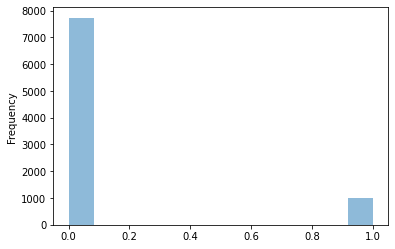

In [26]:
# Audios histogram per type
audios_DF['isEngine'].plot.hist(bins=12, alpha=0.5,)

<AxesSubplot:ylabel='Frequency'>

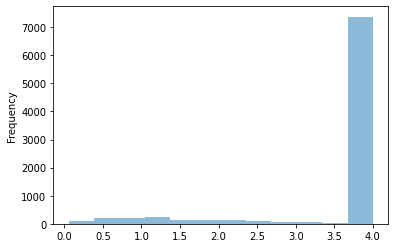

In [24]:
# Audios histogram per duration
audios_DF['duration'].plot.hist(bins=12, alpha=0.5,)

## 2.2. Label the **Audios Dataset** categories - Engine or Not

In [18]:
#  Label if it is an engine sound
audios_DF['isEngine'] = audios_DF['class'].map({'engine_idling': 1, 'air_conditioner':0, 'car_horn':0,
                                       'children_playing':0, 'dog_bark':0, 'drilling':0, 'gun_shot':0,
                                       'jackhammer':0, 'siren':0, 'street_music':0}, na_action=None)

# 3. Process the sound files and extract spectogram

## 3.1. Process and get spectogram

In [19]:
# Method for extracting the audio track + spectogram. The audio intensity is normalized between 0 and 1
def extractSpectogram(filePath):
    SR_CONST=44100
    
    # Extract audio + normalize
    audioMatrix, samplingRate = librosa.load(filePath, sr=SR_CONST, mono=True)
    numSamples = len(audioMatrix)
    timeArray = np.linspace(0, (numSamples-1)/SR_CONST, numSamples)

    audioMatrix = audioMatrix / np.max(audioMatrix) #Normalize per amplitude
    #audioMatrix = audioMatrix / np.max(librosa.feature.rms(y=audioMatrix)) # Normalize per signal RMS
    audio_DF = pd.DataFrame({
                "data": audioMatrix,
                "time":timeArray
                });

    # Extract Mel Spectogram
    spectMatrix = librosa.feature.melspectrogram(y=audioMatrix, sr=44100, n_fft=2048,hop_length=512, n_mels=26)
    spectMatrix = spectMatrix / np.max(spectMatrix) #Normalize per amplitude

    return audio_DF, spectMatrix 


Text(0, 0.5, 'Signal')

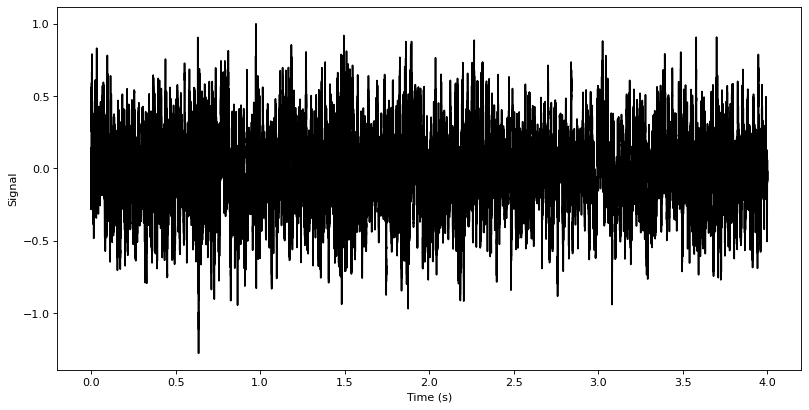

In [20]:
audioMatrix, spectMatrix = extractSpectogram(AUDIOS_PATH + '/100263-2-0-161.wav')

# Plot Audio signal
fAudio = figure(figsize=(12,6), dpi=80)
plt.plot(audioMatrix['time'], audioMatrix['data'], color='black')
plt.xlabel('Time (s)')
plt.ylabel('Signal')

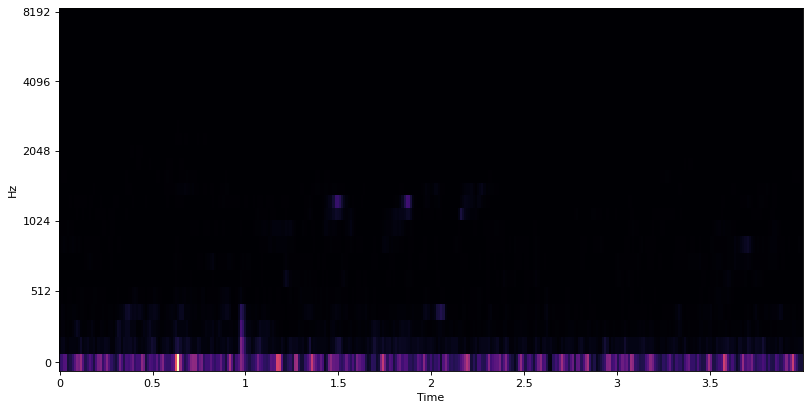

In [21]:
# Plot Mel Spectogram
fSpec = figure(figsize=(12,6), dpi=80)
img = librosa.display.specshow(spectMatrix, x_axis='time',y_axis='mel', sr=44100, fmax=8000)

In [22]:
# Compile all audios in an array of Spectogram Matrices
spectogram_AM = []

# Append all the spectograms matrices in a single array
for idx, rowData in audios_DF.iterrows():
    if(idx%500 == 0):
        print(idx)

    audioMatrix, spectMatrix = extractSpectogram(AUDIOS_PATH + '/' + rowData['filename'])
    spectogram_AM.append(spectMatrix)



0


KeyboardInterrupt: 

# STOPPED HEREE

In [ ]:
# Features definition
def features(full_fname,samples_per_win, texture_size=30):
  x, sr = librosa.load(full_fname, sr=44100, mono=True)

  # Calcular descritores e janela de textura
  filt = np.hanning(texture_size)

  # Spectral centroid
  y0 = librosa.feature.spectral_centroid(x,hop_length = samples_per_win,sr=44100)[0,:]
  y0_ = scipy.signal.oaconvolve(filt, y0)

  # RMS
  y1 = librosa.feature.rms(x,hop_length = samples_per_win,)[0,:]
  y1_ = scipy.signal.oaconvolve(filt, y1)

  # Tempogram
  y2 = librosa.feature.tempogram(x,hop_length = samples_per_win, sr=44100)[0,:]
  y2_ = scipy.signal.oaconvolve(filt, y2)

  return y0_, y1_, y2_, len(y0_) 

In [ ]:
# Sweep all 'df_fil' files and create a features array containing sound data.
# features_array[i][j]  -> feature 'i' and window 'j'

i = 0
centroid_array = []
rms_array = []
tempogram_array = []
len_array = []
class_array = []

#Read all files and extract features
for index, row in  df_fil.iterrows():
  full_fname = diretorio + sounds + str(row['folder']) + '/' + row['filename']
  centroid_array_tmp, rms_array_tmp, tempogram_array_tmp, len_array_tmp = np.array(features(full_fname,512))
  centroid_array.append(centroid_array_tmp)
  rms_array.append(rms_array_tmp)
  tempogram_array.append(tempogram_array_tmp)
  len_array.append(len_array_tmp)
  class_array.append(row['class'])
  i+=1
  if i%10 == 0: #Verbose
    print("Arquivos lidos: ", i)
  
#Cast to numpy type
centroid_array = np.array(centroid_array)
rms_array = np.array(rms_array)
tempogram_array = np.array(tempogram_array)
len_array = np.array(len_array)
class_array = np.array(class_array)

NameError: name 'df_fil' is not defined

In [ ]:
#Create a features dataset
df_feat = pd.DataFrame(columns=('Centroid','RMS','Tempogram','Length','Class'))

df_feat['Centroid'] = centroid_array
df_feat['RMS'] = rms_array
df_feat['Tempogram'] = tempogram_array
df_feat['Length'] = len_array
df_feat['Class'] = class_array

In [ ]:
df_feat.head()

,Centroid,RMS,Tempogram,Length,Class
0,"[-1.1087173507327126e-12, 33.274040011763354, ...","[3.34611475881816e-09, 2.7278437591585612e-05,...","[5.413658939124573e-16, 0.011689722144956791, ...",374,0
1,"[-4.4348694029308505e-12, 23.678930257637766, ...","[-4.591725328004887e-10, 3.260294262957026e-05...","[5.413658939124573e-16, 0.011689722144956791, ...",374,0
2,"[4.4348694029308505e-12, 28.33110960962118, 14...","[1.7227347633086952e-09, 4.5600987249917935e-0...","[5.413658939124573e-16, 0.011689722144956791, ...",374,0
3,"[1.1087173507327126e-12, 24.498219763249207, 1...","[-1.8598622282473528e-09, 4.218332719968574e-0...","[5.413658939124573e-16, 0.011689722144956791, ...",374,0
4,"[5.543586753663563e-12, 27.68029291128097, 135...","[-3.7527843055329414e-10, 3.276225716672013e-0...","[5.413658939124573e-16, 0.011689722144956791, ...",374,0


# 4. Training and predicting with an HMM

## 4.1. Sub dataset creation and features processing

In [ ]:
# Creating 2 sub datasets separating classes
df_feat_0 = df_feat[df_feat.Class.eq(0)] # Non-engine dataset
df_feat_1 = df_feat[df_feat.Class.eq(1)] # Engine Dataset

# Creating 2 sub sub datasets separating train / test
df0_train, df0_test, x, x = train_test_split(df_feat_0, df_feat_0, test_size=0.25)
df1_train, df1_test, x, x = train_test_split(df_feat_1, df_feat_1, test_size=0.25)


### 4.1.1. Train test split for HMM

In [ ]:
centroid_all_0_train = []
rms_all_0_train = []
tempogram_all_0_train = []
len_all_0_train = []

centroid_all_1_train = []
rms_all_1_train = []
tempogram_all_1_train = []
len_all_1_train = []

centroid_all_0_test = []
rms_all_0_test = []
tempogram_all_0_test = []
len_all_0_test = []

centroid_all_1_test = []
rms_all_1_test = []
tempogram_all_1_test = []
len_all_1_test = []

In [ ]:
# Concatenating features from same class sounds in single array

# Features from df_feat_0 concatenation
centroid_all_0_train = np.concatenate( np.array(df0_train.Centroid) ).ravel()
rms_all_0_train = np.concatenate( np.array(df0_train.RMS) ).ravel()
tempogram_all_0_train = np.concatenate( np.array(df0_train.Tempogram) ).ravel()
len_all_0_train = np.array(df0_train.Length)

centroid_all_0_test = np.concatenate( np.array(df0_test.Centroid) ).ravel()
rms_all_0_test = np.concatenate( np.array(df0_test.RMS) ).ravel()
tempogram_all_0_test = np.concatenate( np.array(df0_test.Tempogram) ).ravel()
len_all_0_test = np.array(df0_test.Length)

# Features from df_feat_1 concatenation
centroid_all_1_train = np.concatenate( np.array(df1_train.Centroid) ).ravel()
rms_all_1_train = np.concatenate( np.array(df1_train.RMS) ).ravel()
tempogram_all_1_train = np.concatenate( np.array(df1_train.Tempogram) ).ravel()
len_all_1_train = np.array(df1_train.Length)

centroid_all_1_test = np.concatenate( np.array(df1_test.Centroid) ).ravel()
rms_all_1_test = np.concatenate( np.array(df1_test.RMS) ).ravel()
tempogram_all_1_test = np.concatenate( np.array(df1_test.Tempogram) ).ravel()
len_all_1_test = np.array(df1_test.Length)

## 4.2. HMM creation and training

In [ ]:
# PreditorAn - trained with non engine data
# PreditorBn - trained with engine data

#Train with Centroid
preditorA1 = hmm.GaussianHMM(n_components=8, covariance_type="diag", n_iter=150)
preditorB1 = hmm.GaussianHMM(n_components=8, covariance_type="diag", n_iter=150)

preditorA1.fit(centroid_all_0_train.reshape(-1,1),len_all_0_train)
preditorB1.fit(centroid_all_1_train.reshape(-1,1),len_all_1_train)

#Train with RMS Energy
preditorA2 = hmm.GaussianHMM(n_components=8, covariance_type="diag", n_iter=150)
preditorB2 = hmm.GaussianHMM(n_components=8, covariance_type="diag", n_iter=150)

preditorA2.fit(rms_all_0_train.reshape(-1,1),len_all_0_train)
preditorB2.fit(rms_all_1_train.reshape(-1,1),len_all_1_train)

#Train with Tempogram
preditorA3 = hmm.GaussianHMM(n_components=8, covariance_type="diag", n_iter=150)
preditorB3 = hmm.GaussianHMM(n_components=8, covariance_type="diag", n_iter=150)

preditorA3.fit(tempogram_all_0_train.reshape(-1,1),len_all_0_train)
preditorB3.fit(tempogram_all_1_train.reshape(-1,1),len_all_1_train)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=8, n_iter=150, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

##4.3. Making predictions w/ test data

In [ ]:
# Defining Predict function between 2 models
def predict(x, preditores):
  n = -1
  p0, s0 = preditores[0].decode(x)
  p1, s1 = preditores[1].decode(x)
  if p1 > p0:
    n = 1
    logprob = p1
  else:
    n = 0
    logprob = p0
  return logprob, n

In [ ]:
y_0_test = []
y_1_test = []

y_0_test_act = []
y_1_test_act = []

print("Predizendo com dataset 0 - não é um motor - deve ser gerado por modelo 1")
i=0
for i in range(len(len_all_0_test)-1):
  if i == 0:
    init = 0
    fin = init + len_all_0_test[i]
  else:
    init += len_all_0_test[i-1]
    fin = init + len_all_0_test[i]
  
  p1, n1 = predict(centroid_all_0_test[init:fin].reshape(-1,1), [preditorA1, preditorB1])
  print("Analise A1 - Sequencia foi gerada pelo modelo:", n1, " -- p= ", p1)
  p2, n2 = predict(rms_all_0_test[init:fin].reshape(-1,1), [preditorA2, preditorB2])
  print("Analise A2 - Sequencia foi gerada pelo modelo:", n2, " -- p= ", p2)
  p3, n3 = predict(tempogram_all_0_test[init:fin].reshape(-1,1), [preditorA3, preditorB3])
  print("Analise A3 - Sequencia foi gerada pelo modelo:", n3, " -- p= ", p3)
  y_0_test.append(n1+n2+n3)
  y_0_test_act.append(0)

print("Predizendo com dataset 1 - é um motor - deve ser gerado por modelo 2")
i=0
for i in range(len(len_all_1_test)-1):
  if i == 0:
    init = 0
    fin = init + len_all_1_test[i]
  else:
    init += len_all_1_test[i-1]
    fin = init + len_all_1_test[i]
  
  p1, n1 = predict(centroid_all_1_test[init:fin].reshape(-1,1), [preditorA1, preditorB1])
  print("Analise B1 - Sequencia foi gerada pelo modelo:", n1," -- p= ", p1)
  p2, n2 = predict(rms_all_1_test[init:fin].reshape(-1,1), [preditorA2, preditorB2])
  print("Analise B2 - Sequencia foi gerada pelo modelo:", n2," -- p= ", p2)
  p3, n3 = predict(tempogram_all_1_test[init:fin].reshape(-1,1), [preditorA3, preditorB3])
  print("Analise B3 - Sequencia foi gerada pelo modelo:", n3," -- p= ", p3)
  y_1_test.append(n1+n2+n3)
  y_1_test_act.append(1)

A saída de streaming foi truncada nas últimas 5000 linhas.
Analise A3 - Sequencia foi gerada pelo modelo: 0  -- p=  2621.2433005815587
Analise A1 - Sequencia foi gerada pelo modelo: 0  -- p=  -3914.442546182154
Analise A2 - Sequencia foi gerada pelo modelo: 0  -- p=  72.13685629415832
Analise A3 - Sequencia foi gerada pelo modelo: 0  -- p=  2621.2433005815587
Analise A1 - Sequencia foi gerada pelo modelo: 1  -- p=  -3817.3686588064484
Analise A2 - Sequencia foi gerada pelo modelo: 0  -- p=  427.5449819341295
Analise A3 - Sequencia foi gerada pelo modelo: 0  -- p=  2621.2433005815587
Analise A1 - Sequencia foi gerada pelo modelo: 1  -- p=  -3432.5535304378236
Analise A2 - Sequencia foi gerada pelo modelo: 1  -- p=  476.31742587055476
Analise A3 - Sequencia foi gerada pelo modelo: 0  -- p=  2621.2433005815587
Analise A1 - Sequencia foi gerada pelo modelo: 0  -- p=  -3415.671373837401
Analise A2 - Sequencia foi gerada pelo modelo: 1  -- p=  487.47833073119534
Analise A3 - Sequencia foi ge

In [ ]:
for i in range(len(y_0_test)):
  if y_0_test[i] >= 2:
    y_0_test[i] = 1
  else:
    y_0_test[i] = 0

for i in range(len(y_1_test)):
  if y_1_test[i] >= 2:
    y_1_test[i] = 1
  else:
    y_1_test[i] = 0

## 4.4. Cross check with training data

In [ ]:
y_0_train = []
y_1_train = []

print("Predizendo com dataset 0 - não é um motor - deve ser gerado por modelo 1")
i=0
for i in range(len(len_all_0_train)-1):
  if i == 0:
    init = 0
    fin = init + len_all_0_train[i]
  else:
    init += len_all_0_train[i-1]
    fin = init + len_all_0_train[i]
  
  p1, n1 = predict(centroid_all_0_train[init:fin].reshape(-1,1), [preditorA1, preditorB1])
  #print("Analise A1 - Sequencia foi gerada pelo modelo:", n1, " -- p= ", p1)
  p2, n2 = predict(rms_all_0_train[init:fin].reshape(-1,1), [preditorA2, preditorB2])
  #print("Analise A2 - Sequencia foi gerada pelo modelo:", n2, " -- p= ", p2)
  p3, n3 = predict(tempogram_all_0_train[init:fin].reshape(-1,1), [preditorA3, preditorB3])
  #print("Analise A3 - Sequencia foi gerada pelo modelo:", n3, " -- p= ", p3)
  y_0_train.append(n1+n2+n3)

print("Predizendo com dataset 1 - é um motor - deve ser gerado por modelo 2")
i=0
for i in range(len(len_all_1_train)-1):
  if i == 0:
    init = 0
    fin = init + len_all_1_train[i]
  else:
    init += len_all_1_train[i-1]
    fin = init + len_all_1_train[i]
  
  p1, n1 = predict(centroid_all_1_train[init:fin].reshape(-1,1), [preditorA1, preditorB1])
  #print("Analise B1 - Sequencia foi gerada pelo modelo:", n1," -- p= ", p1)
  p2, n2 = predict(rms_all_1_train[init:fin].reshape(-1,1), [preditorA2, preditorB2])
  #print("Analise B2 - Sequencia foi gerada pelo modelo:", n2," -- p= ", p2)
  p3, n3 = predict(tempogram_all_1_train[init:fin].reshape(-1,1), [preditorA3, preditorB3])
  #print("Analise B3 - Sequencia foi gerada pelo modelo:", n3," -- p= ", p3)
  y_1_train.append(n1+n2+n3)

Predizendo com dataset 0 - não é um motor - deve ser gerado por modelo 1
Predizendo com dataset 1 - é um motor - deve ser gerado por modelo 2


In [ ]:
## Rounding the 3 hmm's predictions to a final prediction

for i in range(len(y_0_train)):
  if y_0_train[i] >= 2:
    y_0_train[i] = 1
  else:
    y_0_train[i] = 0

for i in range(len(y_1_train)):
  if y_1_train[i] >= 2:
    y_1_train[i] = 1
  else:
    y_1_train[i] = 0

## 4.5. Evaluating the HMM results

In [ ]:
y_0_test = np.array(y_0_test)
y_1_test = np.array(y_1_test)
y_0_train = np.array(y_0_train)
y_1_train = np.array(y_1_train)

In [ ]:
y_1_test

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
print("\nTest dataset - Non Engine data correctly classified: ", 100 * (1 - y_0_test.mean()),"% -- Len: ", len(y_0_test))
print("\nTrain dataset - Non Engine data correctly classified: ", 100 * (1-y_0_train.mean()),"% -- Len: ", len(y_0_train))

print("\nTest dataset - Engine data correctly classified: ", 100 * (y_1_test.mean()),"% -- Len: ", len(y_1_test))
print("\nTrain dataset - Engine data correctly classified: ", 100 * (y_1_train.mean()),"% -- Len: ", len(y_1_train))


Test dataset - Non Engine data correctly classified:  91.75607001693959 % -- Len:  1771

Train dataset - Non Engine data correctly classified:  91.58825743319532 % -- Len:  5314

Test dataset - Engine data correctly classified:  29.82456140350877 % -- Len:  228

Train dataset - Engine data correctly classified:  36.01756954612006 % -- Len:  683


In [ ]:
from sklearn.metrics import classification_report

## Append both Y_Act and Y_Predicted

y_actual = []
y_predicted = []

for i in range( len(y_0_test) ):
  y_predicted.append(y_0_test[i])
  y_actual.append(0)

for j in range( len(y_1_test) ):
  y_predicted.append(y_1_test[j])
  y_actual.append(1)

In [ ]:
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1771
           1       0.32      0.30      0.31       228

    accuracy                           0.85      1999
   macro avg       0.61      0.61      0.61      1999
weighted avg       0.84      0.85      0.84      1999

